<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#NeuralProphet" data-toc-modified-id="NeuralProphet-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>NeuralProphet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
pip install neuralprophet

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 56 kB 804 kB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 635 kB/s eta 0:00:01
     |████████████████████████████████| 121 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 51.0 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 46.5 MB/s eta 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730974 sha256=b865b92d20a5d9aee5e420635a0a3b58605d5c47ac226507a5c711472b741793
  Stored in directory: /home/jovyan/.cache/pip/wheels/33/6b/a6/1d9dae2323750f635654952afc74aa8f2d982cded163f43895
Successfully built pymeeus
  Consider a

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Подготовка

In [4]:
df =  pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df_orig = df
df = df.resample('1H').sum()

## Анализ

Text(0.5, 1.0, 'График 1: число заказов в зависимости от даты')

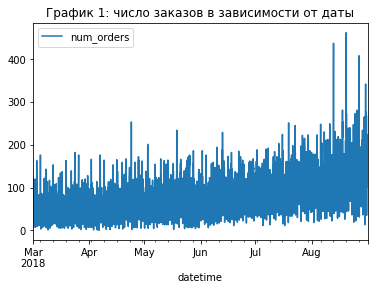

In [6]:
decomposed = seasonal_decompose(df) 
df.plot(ax=plt.gca())
plt.title('График 1: число заказов в зависимости от даты')

График 2: количесво заказав: декомпозиция


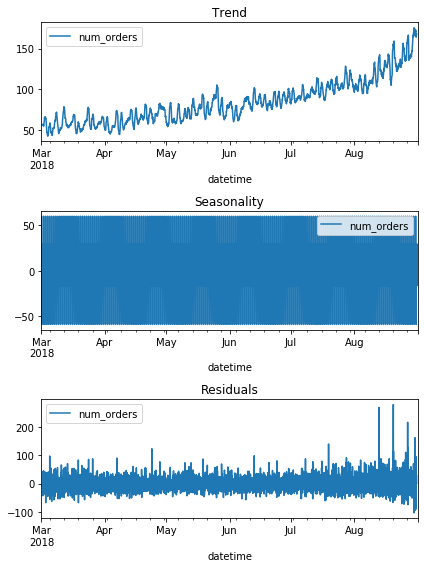

In [7]:
plt.figure(figsize=(6, 8))
print('График 2: количесво заказав: декомпозиция')
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Из разложения данных виидно, что они имеют растущий тренд, не имеют сезонности - такси в аэропорт нужно всегда. Остаточная состовляющая тоже достаточно велика - в конце наблдения пики.

## Обучение
Обучим 2 модели - линейную регрессию для сравнения и NeuralProphet. 
Подговим данные для линейной регрессии.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 24, 2)
df = df.dropna()
features = df.drop('num_orders' , axis=1)
target = df['num_orders']
features_train,features_test, target_train,target_test = train_test_split(features,target, test_size=0.1, shuffle=False)

features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.1, shuffle=False)

 В функцию make_features() аргумент max_lag задаст максимальный размер отставания, а rolling_mean_size задаст ширину окна для вычмсления среднего скользящего. Скользящее среднее как признак задаёт общий тренд временного ряда.
 Для наших целей выбраны значения 24 для лагов и 3 для среднего. Для лагов 24 - так как день ото дня должен быть очень похож, мы логируем сутки. А тренды должны предсказываться на очень коротких интервалах времени - спрос на такси очень быстро меняется(см. график 3). 

Text(0.5, 1.0, 'График 3: Изменение спроса за день')

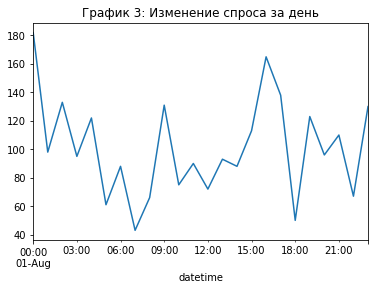

In [9]:
df['2018-08-01':'2018-08-01']['num_orders'].plot()
plt.title('График 3: Изменение спроса за день')

### Линейная регрессия
Для baseline

In [10]:
model_line = LinearRegression()
model_line.fit(features_train,target_train)
pred = model_line.predict(features_val)
print(f"RMSE:\t{(mean_squared_error(target_val,pred)**0.5):.4f}")

RMSE:	34.1579


### NeuralProphet

In [11]:
df_orig = df_orig.reset_index().rename(columns={"datetime": "ds", "num_orders":"y"})

df_train,df_test = train_test_split(df_orig, test_size=0.1, shuffle=False)

df_train, df_val = train_test_split(df_orig, test_size=0.1, shuffle=False)

In [12]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(df_train, freq="H")
future_df = nprophet_model.make_future_dataframe(df_val, 
                                                 periods = len(df_val))

preds_df_1 = nprophet_model.predict(future_df)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s, SmoothL1Loss=0.0237, MAE=4.99, RegLoss=0]


In [13]:
print(f"RMSE:\t{(mean_squared_error(df_val['y'], preds_df_1['yhat1'])**0.5):.4f}")


RMSE:	13.1105


## Тестирование

In [14]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(pd.concat([df_train, df_val]), freq="H")
future_df = nprophet_model.make_future_dataframe(df_test, 
                                                 periods = len(df_test))

preds_df_2 = nprophet_model.predict(future_df)
print(f"RMSE:\t{(mean_squared_error(df_test['y'], preds_df_2['yhat1'])**0.5):.4f}")

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s, SmoothL1Loss=0.0232, MAE=5.27, RegLoss=0]

RMSE:	16.0464


## Вывод
NeuralProphet дает очень высокие показатели RMSE - примерно в 2.6 раза лучше, чем у линейной регрессии.